In [1]:
# generic models as skeletons or jumping off points for more complex models

In [2]:
import os
import numpy as np
import tensorflow as tf 
from tensorflow import keras 
from keras import layers, models
from keras.models import Model
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as f

import torch

from mpl_toolkits import mplot3d


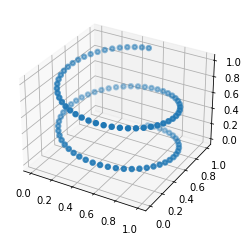

In [3]:
n_data = 100
minmax = MinMaxScaler()
scaler = StandardScaler()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

theta_max = 4 * np.pi
theta = np.linspace(0, theta_max, n_data)
z = theta.reshape(-1, 1)
x =  np.sin(theta).reshape(-1, 1)
y =  np.cos(theta).reshape(-1, 1)
a = np.asarray(range(n_data)).reshape(-1, 1)

minmax.fit(x)
x = minmax.transform(x)
minmax.fit(y)
y = minmax.transform(y)
minmax.fit(z)
z = minmax.transform(z)
minmax.fit(a)
a = minmax.transform(a)

ax.scatter(x, y, z, 'b', lw=2)

x = np.asarray(x)
y = np.asarray(y)
z = np.asarray(z)

plt.show()

In [4]:
x_train = []
for i in range(len(x)):
    x_train.append([x[i], y[i], a[i]])
x_train = np.asarray(x_train).squeeze()


Epoch 1/100
1/1 - 0s - loss: 0.3165 - mse: 0.3165 - mae: 0.4856 - 472ms/epoch - 472ms/step
Epoch 2/100
1/1 - 0s - loss: 0.1189 - mse: 0.1189 - mae: 0.2825 - 0s/epoch - 0s/step
Epoch 3/100
1/1 - 0s - loss: 0.0980 - mse: 0.0980 - mae: 0.2475 - 0s/epoch - 0s/step
Epoch 4/100
1/1 - 0s - loss: 0.0551 - mse: 0.0551 - mae: 0.1852 - 8ms/epoch - 8ms/step
Epoch 5/100
1/1 - 0s - loss: 0.0173 - mse: 0.0173 - mae: 0.1058 - 0s/epoch - 0s/step
Epoch 6/100
1/1 - 0s - loss: 0.0110 - mse: 0.0110 - mae: 0.0946 - 0s/epoch - 0s/step
Epoch 7/100
1/1 - 0s - loss: 0.0136 - mse: 0.0136 - mae: 0.0951 - 0s/epoch - 0s/step
Epoch 8/100
1/1 - 0s - loss: 0.0082 - mse: 0.0082 - mae: 0.0722 - 0s/epoch - 0s/step
Epoch 9/100
1/1 - 0s - loss: 0.0092 - mse: 0.0092 - mae: 0.0843 - 0s/epoch - 0s/step
Epoch 10/100
1/1 - 0s - loss: 0.0168 - mse: 0.0168 - mae: 0.1053 - 0s/epoch - 0s/step
Epoch 11/100
1/1 - 0s - loss: 0.0121 - mse: 0.0121 - mae: 0.0902 - 8ms/epoch - 8ms/step
Epoch 12/100
1/1 - 0s - loss: 0.0050 - mse: 0.0050 - 

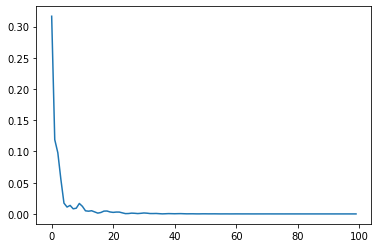

In [5]:
# MODEL IMPLEMENTATION

# DNN generally only have a single hidden layer, as far as n_nuerons usually you want some
# number between the input and output sizes, one rule of thumb is n_samples / (a *(n_in + n_out))
# where 2 <= a <= 10, gunna use that and play with it as needed, 16's (for n_in=32, n_out=1) a good 
# starting point. Also think treating this as a regression problem makes sense since the decile 
# scores are not categorical and are very much a scale. (originally were thinking softmax so output
# activation is now linear)

n_epochs = 100
n_att = len(x_train[1])
n_batch = n_att * 20

# define model 
keras_model = models.Sequential()
keras_model.add(layers.Dense(100, activation='relu', input_dim=n_att))
keras_model.add(layers.Dense(50, activation='relu'))
keras_model.add(layers.Dense(1))

# keras_model.summary()

opt = keras.optimizers.Adam(learning_rate=0.01)
keras_model.compile(loss='mse', optimizer=opt, metrics=['mse', 'mae'])

# MODEL TRAINING 1
# train model
# starting with e50 b32 as a jumping off point
history = keras_model.fit(x_train, z, epochs=n_epochs, batch_size=len(x_train), verbose=2)

plt.plot(history.history['loss'])


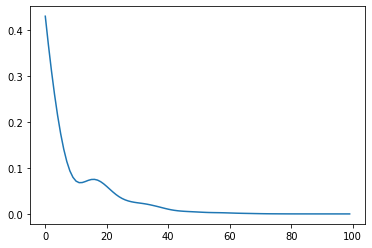

In [6]:
# torch implementation
# define nn

n_inputs = len(x_train[1])

class NN(torch.nn.Module):
    def __init__(self, n_inputs):
        super(NN, self).__init__()
        self.layer1 = torch.nn.Linear(n_inputs, 128) 
        self.layer2 = torch.nn.Linear(128, 64)
        self.layer3 = torch.nn.Linear(64, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = f.relu(x)
        x = self.layer2(x)
        x = f.relu(x)
        x = self.layer3(x)
        return x

model = NN(n_inputs)
opt = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss() 

epochs = 100
x_train = torch.Tensor(x_train)
y_train = torch.Tensor(z)

losses = []

for e in range(epochs):
    pred = model(x_train)
    loss = loss_fn(pred, y_train)

    losses.append(loss.detach().numpy())

    opt.zero_grad()
    loss.backward()
    opt.step()

plt.plot(losses)

In [12]:
i = 0
torch.tensor(np.asarray([x[i][0], y[i][0]]).astype(np.float32)).shape

torch.Size([2])

In [26]:
# predictions
for j in range(10):
    i = j * 10
    torch_pred = model(torch.tensor(np.asarray([x[i][0], y[i][0], a[i][0]]).astype(np.float32))).detach().numpy()[0]
    keras_pred = keras_model.predict(np.asarray([x[i][0], y[i][0], a[i][0]]).reshape(1, -1))[0][0]
    print(str(round(a[i][0], 3)) + ' ' + str(round(x[i][0], 3)) + ' ' + str(round(y[i][0], 3)) + ' |label: ' + str(round(z[i][0], 3)) + ' |torch: ' + str(round(torch_pred, 3)) + ' |keras: ' + str(round(keras_pred, 3)))

0.0 0.5 1.0 |label: 0.0 |torch: 0.006 |keras: 0.007
0.101 0.978 0.648 |label: 0.101 |torch: 0.104 |keras: 0.1
0.202 0.784 0.088 |label: 0.202 |torch: 0.196 |keras: 0.201
0.303 0.191 0.107 |label: 0.303 |torch: 0.307 |keras: 0.302
0.404 0.033 0.678 |label: 0.404 |torch: 0.392 |keras: 0.403
0.505 0.532 0.999 |label: 0.505 |torch: 0.509 |keras: 0.505
0.606 0.986 0.618 |label: 0.606 |torch: 0.621 |keras: 0.605
0.707 0.757 0.071 |label: 0.707 |torch: 0.709 |keras: 0.706
0.808 0.167 0.127 |label: 0.808 |torch: 0.797 |keras: 0.808
0.909 0.045 0.708 |label: 0.909 |torch: 0.92 |keras: 0.907


In [ ]:
reg_x = []
reg_y = []
reg_z = []
reg_z_keras = []

for i in range(n_data):
    if i % 4 == 0:
        reg_x.append(x[i])
        reg_y.append(y[i])

        # torch
        model_input = np.asarray([x[i][0], y[i][0], a[i][0]])
        model_input = torch.tensor(model_input.astype(np.float32))
        pred = model(model_input).detach().numpy()[0]

        # keras
        keras_pred = keras_model.predict(np.asarray([x[i][0], y[i][0], a[i][0]]).reshape(1, -1))[0][0]
        
        # print(str(x[i][0]) + ' ' + str(y[i][0]) + ' ' + str(z[i][0]) + ' : torch z:' + str(pred) + ' : keras z:' + str(keras_pred))
        reg_z.append(pred)
        reg_z_keras.append(keras_pred)

reg_x = np.asarray(reg_x).reshape(-1, 1)
reg_y = np.asarray(reg_y).reshape(-1, 1)
reg_z = np.asarray(reg_z).reshape(-1, 1)
reg_z_keras = np.asarray(reg_z_keras).reshape(-1, 1)
    

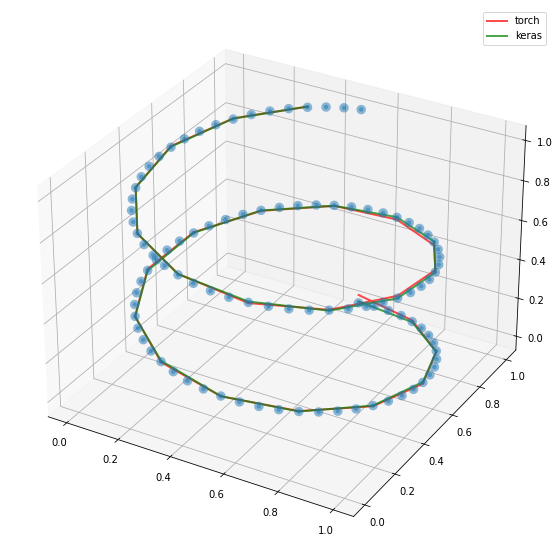

In [ ]:

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter3D(x, y, z, lw=5, alpha=0.5)
line1 = ax.plot(reg_x.squeeze(), reg_y.squeeze(), reg_z.squeeze(), lw=2, color='red', alpha=0.7)
line2 = ax.plot(reg_x.squeeze(), reg_y.squeeze(), reg_z_keras.squeeze(), lw=2, color='green', alpha=0.7)

ax.legend([line1[0], line2[0]], ['torch', 'keras'])
plt.show()